In [1]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%matplotlib inline
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
!pip install cython


In [3]:
cd drive/My Drive/app/RFBNet-master

/content/drive/My Drive/app/RFBNet-master


In [0]:
# !python train_RFB.py -b 32 -d ANPR -v RFB_vgg -s 300 --num_workers 0 --resume_epoch 310 --resume_net ./weights/RFB_vgg_ANPR_epoches_310.pth --lr 0.0001

In [0]:
# !python demo.py --trained_model ./weights/RFB_vgg_ANPR_epoches_280.pth --i 11666460.jpg

In [0]:
from __future__ import print_function
import os
import pickle
import argparse
import torch
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import numpy as np
from torch.autograd import Variable
from data import VOCroot
from data import BaseTransform, COCO_300
import cv2
from layers.functions import Detect,PriorBox
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from utils.nms_wrapper import nms
from utils.timer import Timer
from models.RFB_Net_vgg import build_net
from PIL import Image, ImageDraw
def test(img_path, model_path='./weights/RFB_vgg_ANPR_epoches_270.pth'):
    img_path = img_path
    trained_model = model_path
    if torch.cuda.is_available():
        cuda = True
    cfg = COCO_300
    priorbox = PriorBox(cfg)
    with torch.no_grad():
        priors = priorbox.forward()
        if cuda:
            priors = priors.cuda()
    numclass = 2
   
    img = cv2.imread(img_path)
    scale = torch.Tensor([img.shape[1], img.shape[0],
                         img.shape[1], img.shape[0]])
    net = build_net('test', 300, numclass)    # initialize detector

    transform = BaseTransform(net.size, (123, 117, 104), (2, 0, 1))
    with torch.no_grad():
        x = transform(img).unsqueeze(0)
        x = Variable(x)
        if cuda:
            x = x.cuda()
            scale = scale.cuda()
    state_dict = torch.load(trained_model)
    # create new OrderedDict that does not contain `module.`
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        head = k[:7]
        if head == 'module.':
            name = k[7:] # remove `module.`
        else:
            name = k
        new_state_dict[name] = v
    net.load_state_dict(new_state_dict)
    net.eval()
    if cuda:
        net = net.cuda()
        cudnn.benchmark = True
    else:
        net = net.cpu()
    print('Finished loading model!')
    # print(net)
    detector = Detect(numclass,0,cfg)
    out = net(x)      # forward pass

    boxes, scores = detector.forward(out,priors)
    boxes = boxes[0]
    scores=scores[0]
    boxes *= scale
    boxes = boxes.cpu().numpy()
    scores = scores.cpu().numpy()
    # Create figure and axes
    # Display the image    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    # scale each detection back up to the image
    for j in range(1, numclass):
        print(max(scores[:, j]))
        inds = np.where(scores[:, j] > 0.6)[0]
        #conf > 0.6
        if inds is None:
            continue
        c_bboxes = boxes[inds]
        c_scores = scores[inds, j]
        c_dets = np.hstack((c_bboxes, c_scores[:, np.newaxis])).astype(
            np.float32, copy=False)
        keep = nms(c_dets, 0.6)
        c_dets = c_dets[keep, :]
        c_bboxes=c_dets[:, :4]
        for bbox in c_bboxes:
            # Create a Rectangle patch
            rect = patches.Rectangle((int(bbox[0]), int(bbox[1])),int(bbox[2]) - int(bbox[0]) + 1, int(bbox[3]) - int(bbox[1]) + 1,linewidth=1,fill=None, edgecolor='r')
            # Add the patch to the Axes
            ax.add_patch(rect)
        plt.show()



Finished loading model!
0.9999211


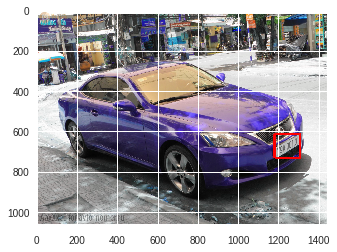

In [8]:
test('11664587.jpg')